# Epoch propagation for astrometry and radial velocities

This notebook illustrates the use of the `EpochPropagation` from the `pygaia.astrometry.coordinates` module. A couple of remarks:

* One cannot propagate the covariance matrix of the astrometric parameters + radial velocity without knowing the astrometric parameters and radial velocity of the source.
* Rigorous epoch propagation requires the radial velocity of the source and its uncertainty. If this is not known one can set the radial velocity to zero and its uncertainty to the velocity dispersion of the population the source is drawn from.
* One of the questions illusstrated in this notebook is how much the radial velocity and its uncertainty contributes to the future/past positional uncertainties.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cycler import cycler
from pygaia.astrometry.coordinates import EpochPropagation, angular_distance
from pygaia.astrometry.constants import au_km_year_per_sec
from pygaia.utils import construct_covariance_matrix
from pygaia.errors.astrometric import parallax_uncertainty, position_uncertainty, proper_motion_uncertainty

from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.table import Table, vstack
from scipy.stats import randint
from scipy.special import erf

plt.style.use("./agab.mplstyle")

## Get Barnard's star data from Gaia DR3

Barnard's star is HIP 87937 and Gaia DR3 4472832130942575872.

In [2]:
job = Gaia.launch_job_async("""SELECT * FROM gaiadr3.gaia_source  WHERE source_id=4472832130942575872""", \
                           dump_to_file=False)
barnard_dr3 = job.get_results()[0]

#customSimbad = Simbad()
#customSimbad.add_votable_fields('rv_value', 'rvz_error')
#barnard_simbad = customSimbad.query_object("Barnard's star")

a0_barnard = np.array([barnard_dr3['ra']*np.pi/180.0, barnard_dr3['dec']*np.pi/180.0,
                       barnard_dr3['parallax'],
                       barnard_dr3['pmra'], barnard_dr3['pmdec'], 
                       barnard_dr3['radial_velocity']])
a0_barnard_novrad = np.array([barnard_dr3['ra']*np.pi/180.0, barnard_dr3['dec']*np.pi/180.0,
                              barnard_dr3['parallax'],
                              barnard_dr3['pmra'], barnard_dr3['pmdec'], 
                              0.0])

cvec0 = np.array([
    barnard_dr3['ra_error'], 
    barnard_dr3['dec_error'],
    barnard_dr3['parallax_error'],
    barnard_dr3['pmra_error'],
    barnard_dr3['pmdec_error'],
    barnard_dr3['ra_dec_corr'], 
    barnard_dr3['ra_parallax_corr'], 
    barnard_dr3['ra_pmra_corr'],
    barnard_dr3['ra_pmdec_corr'], 
    barnard_dr3['dec_parallax_corr'], 
    barnard_dr3['dec_pmra_corr'], 
    barnard_dr3['dec_pmdec_corr'], 
    barnard_dr3['parallax_pmra_corr'],
    barnard_dr3['parallax_pmdec_corr'],
    barnard_dr3['pmra_pmdec_corr']
])
c0_barnard = construct_covariance_matrix(cvec0, barnard_dr3['parallax'], 
                                 barnard_dr3['radial_velocity'], barnard_dr3['radial_velocity_error'])
vdisp = 50
c0_barnard_novrad = construct_covariance_matrix(cvec0, barnard_dr3['parallax'], 0, vdisp)

INFO: Query finished. [astroquery.utils.tap.core]


### Position uncertainty as a function of epoch for Barnard's star

The plot below shows the semi-major axis of the position uncertainties for Barnard's star as a function of epoch. The case where the radial velocity of Barnard's star would not be known is also shown (where the uncertainty is set to 50 km/s, more or less the velocity dispersion of the population the star is drawn from).

In the case of very nearby stars (such as this one) the uncertainty on the radial velocity can become the dominant  term in the uncertainty on future positions. This is a manifestation of the perspective acceleration effect.

1.5151729039613386


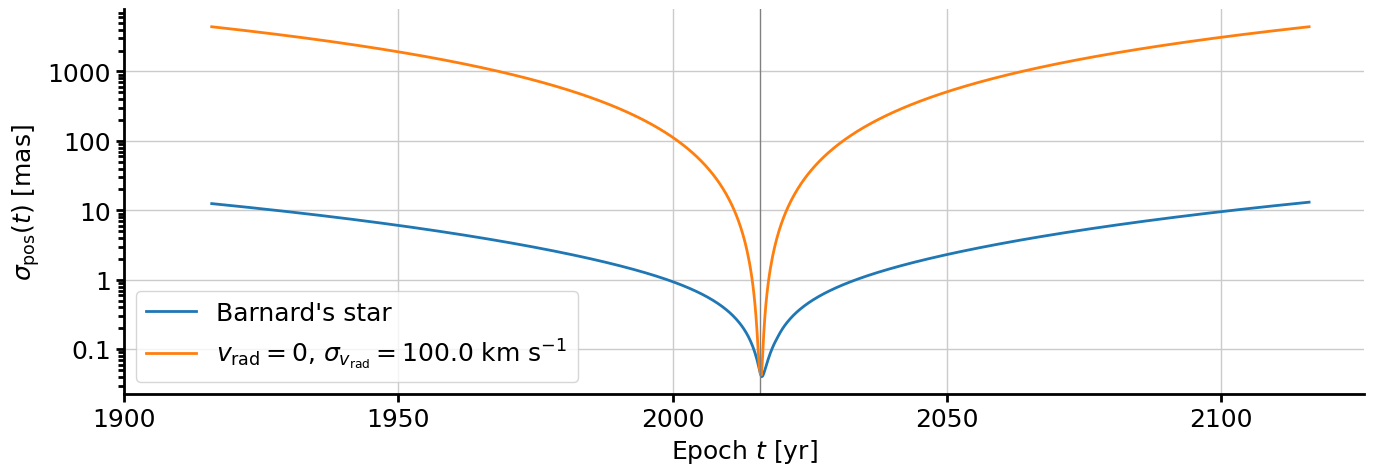

In [11]:
epp = EpochPropagation()
refepoch = barnard_dr3['ref_epoch']

npoints = 1001
newepochs = np.linspace(refepoch-100, refepoch+100, npoints)
a1s = np.zeros((npoints,6))
a1s_novrad = np.zeros((npoints,6))
c1s = np.zeros((npoints,6,6))
c1s_novrad = np.zeros((npoints,6,6))
for k in range(npoints):
    a1, c1 = epp.propagate_astrometry_and_covariance_matrix(a0_barnard, c0_barnard, refepoch, newepochs[k])
    c1s[k] = c1
    a1s[k] = a1
    a1, c1 = epp.propagate_astrometry_and_covariance_matrix(a0_barnard_novrad, c0_barnard_novrad, refepoch, newepochs[k])
    c1s_novrad[k] = c1
    a1s_novrad[k] = a1
    
# Calculate semi-major axis of position error ellipse, sigma_pos
fsqr = -2.0*np.log(1.0-erf(1.0/np.sqrt(2.0)))
sigmapos1 = 0.5*(c1s[:,0,0] + c1s[:,1,1] + np.sqrt((c1s[:,1,1]-c1s[:,0,0])**2 + 4*c1s[:,0,1]**2))
sigmapos1 = np.sqrt(fsqr*sigmapos1)
sigmapos1_novrad = 0.5*(c1s_novrad[:,0,0] + c1s_novrad[:,1,1] + 
                 np.sqrt((c1s_novrad[:,1,1]-c1s_novrad[:,0,0])**2 + 4*c1s_novrad[:,0,1]**2))
sigmapos1_novrad = np.sqrt(fsqr*sigmapos1_novrad)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

ax.semilogy(newepochs, sigmapos1, label="Barnard's star")
ax.semilogy(newepochs, sigmapos1_novrad, 
            label="$v_\mathrm{{rad}}=0$, $\sigma_{{v_\mathrm{{rad}}}}={0}$ km s$^{{-1}}$".format(vdisp))
#ax.semilogy(newepochs, np.sqrt(sigmapos1_novrad-sigmapos1))
ax.set_xlabel(r'Epoch $t$ [yr]')
ax.set_ylabel(r'$\sigma_\mathrm{pos}(t)$ [mas]')
ax.axvline(x=refepoch, c='gray', lw=1)
ax.set_xticks([1900, 1950, 2000, 2050, 2100], minor=False)
ax.set_xticklabels(['1900', '1950', '2000', '2050', '2100'], minor=False)
ax.set_yticks([0.1,1,10,100,1000], minor=False)
ax.set_yticklabels(['0.1','1','10','100','1000'], minor=False)
ax.grid(True)
ax.legend()

plt.show()

### Astrometry as a function of time for Barnard's star

The following plots show how the predicted astrometric and radial velocity parameters differ between the case where the radial velocity of Barnard's start is known and when it is not. Note how the propagated positions and radial velocities are not much affected, while the proper motions and parallax changes are significantly different for the different radial velocity values.

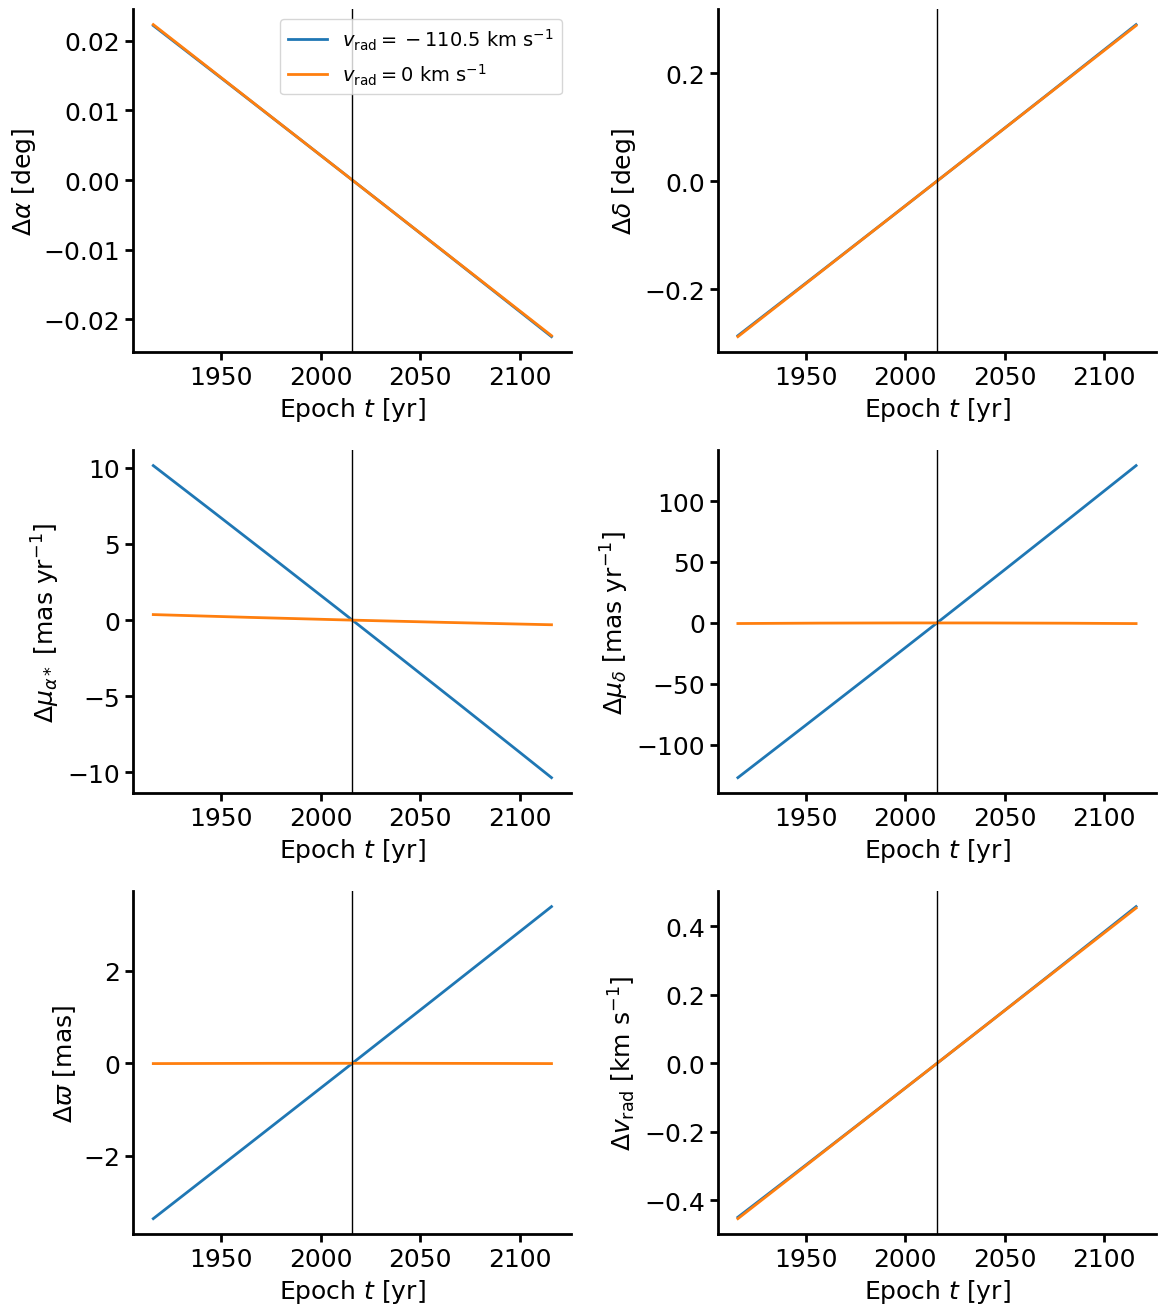

In [4]:
fig = plt.figure(figsize=(12,18*0.75), tight_layout=True)
axra = fig.add_subplot(3, 2, 1)
axdec = fig.add_subplot(3, 2, 2)
axpmra = fig.add_subplot(3, 2, 3)
axpmdec = fig.add_subplot(3, 2, 4)
axvarpi = fig.add_subplot(3, 2, 5)
axvrad = fig.add_subplot(3, 2, 6)

ra = a1s[:,0]
ra[ra<0] = ra[ra<0]+2*np.pi
dec = a1s[:,1]
ra_novrad = a1s_novrad[:,0]
ra_novrad[ra_novrad<0] = ra_novrad[ra_novrad<0]+2*np.pi
dec_novrad = a1s_novrad[:,1]

axra.plot(newepochs, np.rad2deg(ra)-barnard_dr3['ra'], label=rf"$v_\mathrm{{rad}}={barnard_dr3['radial_velocity']:.1f}$ km s$^{{-1}}$")
axra.plot(newepochs, np.rad2deg(ra_novrad)-barnard_dr3['ra'], label=r"$v_\mathrm{rad}=0$ km s$^{-1}$")
axra.set_xlabel(r"Epoch $t$ [yr]")
axra.set_ylabel(r"$\Delta \alpha$ [deg]")
axra.axvline(x=refepoch, c='k',lw=1)
axra.legend(fontsize=14)

axdec.plot(newepochs, np.rad2deg(dec)-barnard_dr3['dec'])
axdec.plot(newepochs, np.rad2deg(dec_novrad)-barnard_dr3['dec'])
axdec.set_xlabel(r"Epoch $t$ [yr]")
axdec.set_ylabel(r"$\Delta \delta$ [deg]")
axdec.axvline(x=refepoch, c='k',lw=1)

axpmra.plot(newepochs, a1s[:,3] - barnard_dr3['pmra'])
axpmra.plot(newepochs, a1s_novrad[:,3] - barnard_dr3['pmra'])
axpmra.set_xlabel(r"Epoch $t$ [yr]")
axpmra.set_ylabel(r"$\Delta\mu_{\alpha*}$ [mas yr$^{-1}$]")
axpmra.axvline(x=refepoch, c='k',lw=1)
                                     
axpmdec.plot(newepochs, a1s[:,4] - barnard_dr3['pmdec'])
axpmdec.plot(newepochs, a1s_novrad[:,4] - barnard_dr3['pmdec'])
axpmdec.set_xlabel(r"Epoch $t$ [yr]")
axpmdec.set_ylabel(r"$\Delta\mu_\delta$ [mas yr$^{-1}$]")
axpmdec.axvline(x=refepoch, c='k',lw=1)
                                     
axvarpi.plot(newepochs, a1s[:,2] - barnard_dr3['parallax'])
axvarpi.plot(newepochs, a1s_novrad[:,2] - barnard_dr3['parallax'])
axvarpi.set_xlabel(r"Epoch $t$ [yr]")
axvarpi.set_ylabel(r"$\Delta\varpi$ [mas]")
axvarpi.axvline(x=refepoch, c='k',lw=1)
                                     
axvrad.plot(newepochs, a1s[:,5]/a1s[:,2]*au_km_year_per_sec - barnard_dr3['radial_velocity'])
axvrad.plot(newepochs, a1s_novrad[:,5]/a1s_novrad[:,2]*au_km_year_per_sec )
axvrad.set_xlabel(r"Epoch $t$ [yr]")
axvrad.set_ylabel(r"$\Delta v_\mathrm{rad}$ [km s$^{-1}$]")
axvrad.axvline(x=refepoch, c='k',lw=1)
                                     
plt.show()

## Show the evolution of the uncertainties in the positions of stars that form the secondary Gaia celestial reference frame

The Gaia Celestial Reference Frame (GCRF) is formally defined by the Gaia catalogue positions of QSOs/AGNs, where for Gaia DR3 a set of 1.6 million such objects is used. See [Gaia Collaboration, Klioner, et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...667A.148G/abstract) for details. The stars in the Gaia catalogue form a secondary reference frame which is used as a reference for telescope pointing and astrometric reduction. 

The plot below shows how the position uncertainties in this secondary frame evolve over the course of time (both forward and backward in time). The epoch propagation functions from PyGaia are used to make this plot. It shows the predicted position uncertainties for sources at $G=12$, $15$, $18$, $20$. The plot is base on the graphic created by Francois Mignard for the science case for the Gaia mission extension.

To get representative astrometric parameters for the sources a random sampe of $\sim10\,000$ sources is queried from the Gaia archive and the average values of the astrometric parameters are used. The queries are of this form:
```sql
select count(*) as n, 
avg(ra) as ra_avg, avg(dec) as dec_avg, 
avg(parallax) as parallax_avg, 
avg(pmra) as pmra_avg, avg(pmdec) as pmdec_avg
from gaiadr3.gaia_source
where phot_g_mean_mag between 17.95 and 18.05
and random_index<1000000
and astrometric_params_solved>3
```
Where the limit on the `random_index` is $10^8$, $10^7$, and $10^6$ for stars around $G=12$, $G=15$, and $G=18$ or $G=20$, respecitvely.

The radial velocity is assumed to be unknown (will be true for 95 per cent of stars in the Gaia catalogue even for DR5) and set to zero. The uncertainty on $v_\mathrm{rad}$ is included as a velocity dispersion of $100$ km s$^{-1}$. The position uncertainty in the plot is shown as the semi-major axis $\sigma_\mathrm{pos,max}$ of the covariance matrix for $(\alpha*,\delta)$. The value is calculated according to equation (B.1) in [Lindegren et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A...2L).

\begin{equation}
    \sigma_\mathrm{pos,max} = f \sqrt{\frac{1}{2}(C_{00}+C_{11}) + \frac{1}{2} \sqrt{(C_{11}-C_{00})^2+4C_{01}^2}}\,,
\end{equation}
where $C_{00}=\sigma_{\alpha*}^2$, $C_{11}=\sigma_\delta^2$, and $C_{01}=\sigma_{\alpha*}\sigma_\delta\rho^{\alpha*}_\delta$. The factor $f$ converts the semi-major axis of the uncertainty ellipse to the equivalent of a $1-\sigma$ limit for a 1D normal distribution (where here a 2D normal distribution describes the position uncertainty).

\begin{equation}
    f^2 = -2\left(\ln \left(1-\text{erf}\left( \frac{1}{\sqrt{2}} \right)\right)\right)\,.
\end{equation}

Some remarks on the plot below:
* At a given source magnitude the CRF is more precise for Gaia DR5 than Gaia DR4 and also degrades more slowly.
* For the stars at $G=12$ one reaches the calibration floor in the astrometric uncertainties. This fact in combination with the on average larger parallaxes for $G=12$ stars with respect to $G=15$ stars explains why the positon uncertainty curve for Gaia DR5 at $G=12$ lies mostly above the uncertainty curve for Gaia DR4 at $G=15$.

In [5]:
# Load some sample astrometric data for generating random source parameters.

g12mean = Table.read("G12_average_astrometry.vot", format="votable")[0]
g15mean = Table.read("G15_average_astrometry.vot", format="votable")[0]
g18mean = Table.read("G18_average_astrometry.vot", format="votable")[0]
g20mean = Table.read("G20_average_astrometry.vot", format="votable")[0]

meansource = vstack([g12mean, g15mean, g18mean, g20mean])
meansource['radial_velocity']=0.0
meansource['ra_avg'] = np.deg2rad(meansource['ra_avg'])
meansource['dec_avg'] = np.deg2rad(meansource['dec_avg'])
a0 = meansource.to_pandas().loc[:,'ra_avg':'radial_velocity'].to_numpy().T

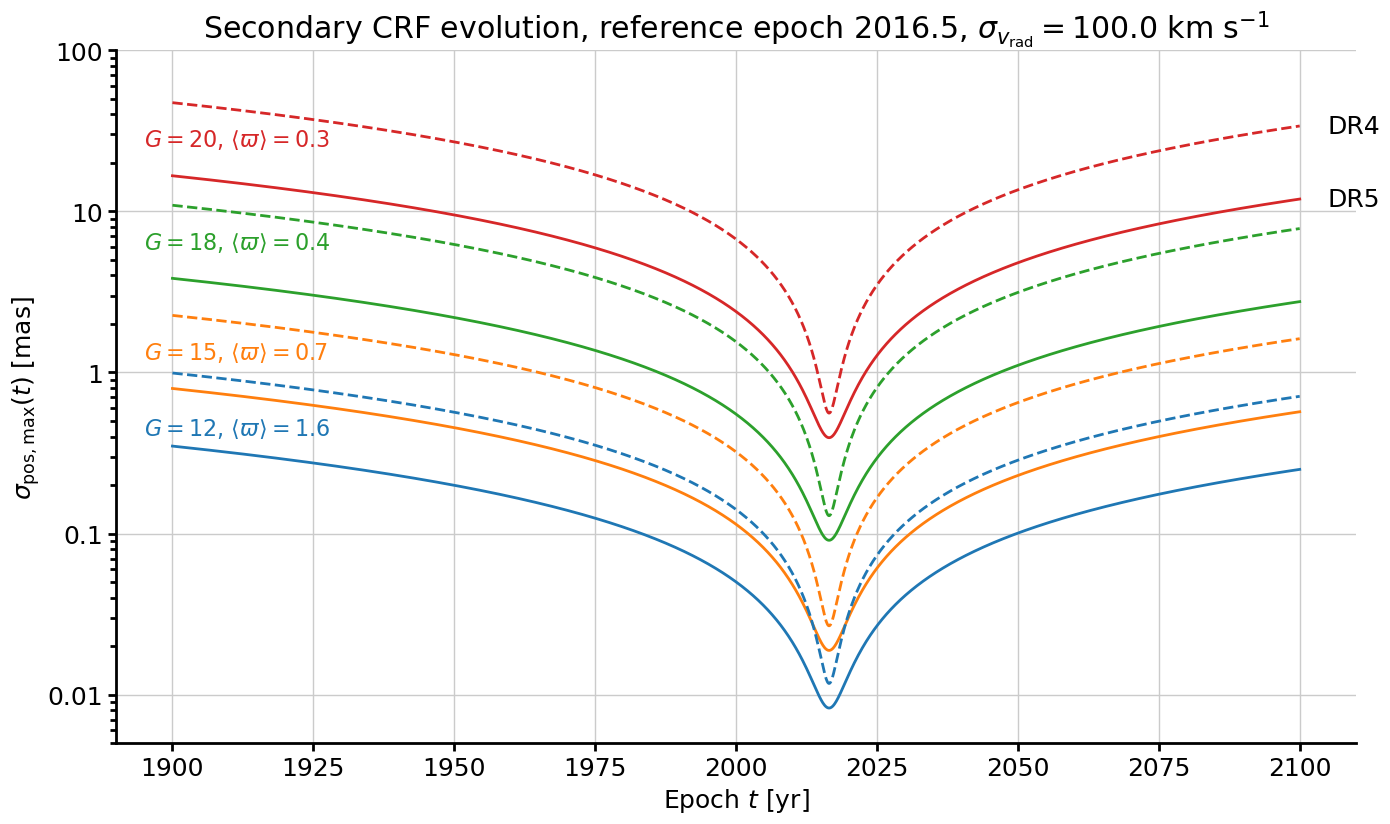

In [22]:
G = np.array([12.0, 15.0, 18.0, 20.0])

# Assume a radial velocity dispersion to account for the unknown radial velocities (which is the case for most stars in the Gaia catalogue).
vdisp = 100.0

refepoch = 2016.5
npoints = 2001
newepochs = np.linspace(1900, 2100, npoints)

custom_cycler = (cycler(color=plt.cm.get_cmap("tab10").colors[0:4]))
fig, axm = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
axm.set_prop_cycle(custom_cycler)
glaby = np.zeros(4)

for rls, lins, in zip(["dr5", "dr4"], ["-", "--"]):
    ra_error, dec_error = position_uncertainty(G, release=rls)
    ra_error = ra_error/1000.0
    dec_error = dec_error/1000.0
    parallax_error = parallax_uncertainty(G, release=rls)
    parallax_error = parallax_error/1000.0
    pmra_error, pmdec_error = proper_motion_uncertainty(G, release=rls)
    pmra_error = pmra_error/1000.0
    pmdec_error = pmdec_error/1000.0

    g12cvec = np.zeros(15)
    g12cvec[0:5] = np.array([ra_error[0], dec_error[0], parallax_error[0], pmra_error[0], pmdec_error[0]])
    g12c = construct_covariance_matrix(g12cvec, g12mean['parallax_avg'], 0.0, vdisp)

    g15cvec = np.zeros(15)
    g15cvec[0:5] = np.array([ra_error[1], dec_error[1], parallax_error[1], pmra_error[1], pmdec_error[1]])
    g15c = construct_covariance_matrix(g15cvec, g15mean['parallax_avg'], 0.0, vdisp)

    g18cvec = np.zeros(15)
    g18cvec[0:5] = np.array([ra_error[2], dec_error[2], parallax_error[2], pmra_error[2], pmdec_error[2]])
    g18c = construct_covariance_matrix(g18cvec, g18mean['parallax_avg'], 0.0, vdisp)

    g20cvec = np.zeros(15)
    g20cvec[0:5] = np.array([ra_error[3], dec_error[3], parallax_error[3], pmra_error[3], pmdec_error[3]])
    g20c = construct_covariance_matrix(g20cvec, g20mean['parallax_avg'], 0.0, vdisp)

    c0 = np.stack([g12c, g15c, g18c, g20c])

    c1s = np.zeros((G.size,npoints,6,6))
    for k in range(npoints):
        a1, c1 = epp.propagate_astrometry_and_covariance_matrix(a0, c0, refepoch, newepochs[k])
        for l in range(G.size):
            c1s[l,k] = c1[l]

    # Caclualte the semi-major axis of the position uncertainty ellipse.
    sigmapos = np.zeros((4,npoints))
    for k in range(G.size):
        sigmapos[k] = 0.5*(c1s[k,:,0,0] + c1s[k,:,1,1] + 
                                 np.sqrt((c1s[k,:,1,1]-c1s[k,:,0,0])**2 + 4*c1s[k,:,0,1]**2))
        sigmapos[k] = np.sqrt(fsqr*sigmapos[k])
        glaby[k]=glaby[k]+0.5*np.log10(sigmapos[k][0])

    for k in range(G.size):
        axm.semilogy(newepochs, sigmapos[k], ls=lins,
                     label=r"$G={0}$, $\sigma_{{v_\mathrm{{r}}}}={1:.1f}$ km s$^{{-1}}$, $\varpi={2:.2f}$ mas".format(G[k], vdisp, a0[2,k]))
        if k == G.size-1:
            axm.text(2105, sigmapos[k][-1], rls.upper(), va='center')
    axm.set_xlabel(r'Epoch $t$ [yr]')
    axm.set_ylabel(r'$\sigma_\mathrm{pos,max}(t)$ [mas]')
    axm.set_ylim(0.005,100)
    axm.set_yticks([0.01, 0.1, 1, 10, 100])
    axm.set_yticklabels(['0.01', '0.1', '1', '10', '100'])

glaby[0] = 1.5*glaby[0]
for k, kleur, plx in zip(range(G.size), custom_cycler, a0[2]):
    axm.text(1895, np.power(10,glaby[k]), rf"$G={G[k]:.0f}$, $\langle\varpi\rangle={plx:.1f}$", c=kleur['color'], va='center', fontsize=16)    

#axm.legend(fontsize=12, loc='lower left')
axm.grid(True)
axm.set_title(rf"Secondary CRF evolution, reference epoch {refepoch}, $\sigma_{{v_\mathrm{{rad}}}}={vdisp}$ km s$^{{-1}}$")

plt.show()